In [1]:
import h5py
import numpy as np
SAVES_PATH = "/home/ubuntu/saves/"
BATCH = 64

def get_first():
  with h5py.File('dataset.h5', 'r') as f:
      X = np.array(f['X'][:8384], dtype=np.float32)
      np.divide(X, 255, out=X)
      Y = np.array(f['Y'][:8384], dtype=np.float32)
      np.divide(Y, 255, out=Y)
  return X, Y

def get_second():
  with h5py.File('dataset.h5', 'r') as f:
      X = np.array(f['X'][8384:8384*2], dtype=np.float32)
      np.divide(X, 255, out=X)
      Y = np.array(f['Y'][8384:8384*2], dtype=np.float32)
      np.divide(Y, 255, out=Y)
  return X, Y

def get_third():
  with h5py.File('dataset.h5', 'r') as f:
      X = np.array(f['X'][8384*2:], dtype=np.float32)
      np.divide(X, 255, out=X)
      Y = np.array(f['Y'][8384*2:], dtype=np.float32)
      np.divide(Y, 255, out=Y)
  return X, Y

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, CuDNNGRU, CuDNNLSTM, \
    TimeDistributed, Reshape, Input, Dropout, RepeatVector, MaxPooling2D, \
    UpSampling2D, Cropping2D
from keras.activations import relu

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
T_pred = 16
T_in = 16
vid_l = T_in + T_pred
IMG_H = 125
IMG_W = 125
IMG_CH = 3

In [4]:
TD = TimeDistributed

inputs = Input(shape=(T_in, IMG_H, IMG_W, IMG_CH))

# Apply convolutions on the initial image input with increasing channel size.
conv_x = TD(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(inputs)
conv_x = TD(MaxPooling2D(pool_size=(2, 2)))(conv_x)
conv_x = TD(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(conv_x)
conv_x = TD(MaxPooling2D(pool_size=(2, 2)))(conv_x)
conv_x = TD(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(conv_x)
print("Exit initial conv: ", conv_x.shape)

# We pass the flattened convolution output into a CuDNN-optimized LSTM.
# Outputs are disregarded for training but form the "encoded" representation.
enc_x = Reshape((T_in, -1))(conv_x)
encoded_output, hidden, cell = CuDNNLSTM(1024, return_state=True, return_sequences=False)(enc_x)

# Decode model output.
dec_raw_x = RepeatVector(T_pred)(encoded_output) # Input(shape=(None, 512,))
dec_x, _, _ = CuDNNLSTM(1024, return_state=True, return_sequences=True)(dec_raw_x, initial_state=[hidden, cell])
dec_x = TD(Reshape((8, 8, 16)))(dec_x)
print("Exit seq2seq: ", dec_x.shape)

# Upsample
dec_x = TD(Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)
dec_x = TD(Conv2D(64, kernel_size=(4, 4), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)
dec_x = TD(Conv2D(32, kernel_size=(4, 4), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)

predictions = TD(Conv2D(3, kernel_size=(2,2), strides=(1,1), activation='sigmoid'))(dec_x)
print("Final shape:", predictions.shape)


model = Model(inputs=inputs, outputs=predictions)

Exit initial conv:  (?, 16, 3, 3, 128)
Exit seq2seq:  (?, 16, 8, 8, 16)
(?, 16, 18, 18, 64)
(?, 16, 45, 45, 64)
(?, 16, 126, 126, 32)
Final shape: (?, 16, 125, 125, 3)


In [5]:
# X, Y = get_first()
# model.compile(optimizer=RMSprop(0.002), loss='binary_crossentropy')
# model.fit(X, Y, batch_size=32, epochs=3, shuffle=True)
# del(X)
# del(Y)
model.load_weights("model_weights_2.h5")
X, Y = get_third()
model.compile(optimizer=RMSprop(0.002), loss='binary_crossentropy')
model.fit(X, Y, batch_size=32, epochs=3, shuffle=True)
model.save_weights("model_weights_3.h5")

Epoch 1/3
736/736 [==============================] - 29s 39ms/step - loss: 0.4636
Epoch 2/3
736/736 [==============================] - 22s 30ms/step - loss: 0.4621
Epoch 3/3
736/736 [==============================] - 22s 30ms/step - loss: 0.4615


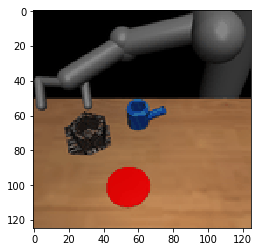

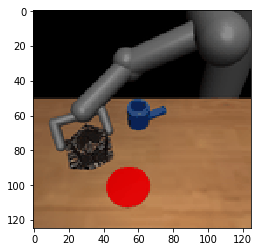

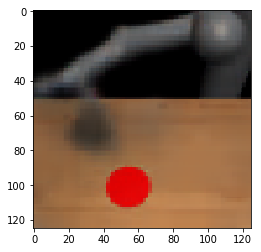

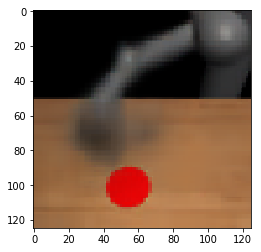

IndexError: index 1 is out of bounds for axis 0 with size 1

In [12]:
GAP = 25
model.load_weights("model_weights_2.h5")
with h5py.File('dataset.h5', 'r') as f:
    X = np.array(f['X'][-1 - GAP], dtype=np.float32)
    np.divide(X, 255, out=X)
    Y = np.array(f['Y'][-1 - GAP], dtype=np.float32)
    np.divide(Y, 255, out=Y)

import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.array(Y[0] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(Y[15] * 255, dtype=np.uint8))
plt.show()
preds = model.predict(np.array([X]))
plt.imshow(np.array(preds[0][0] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(preds[0][15] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(preds[0][15] * 255 - preds[1][0] * 255, dtype=np.uint8))
plt.show()

3x3 32-channel Conv2D
2x2 MaxPooling2D
3x3 64-channel Conv2D
2x2 MaxPooling2D
3x3 128-channel Conv2D

1024-hidden LSTM
1024-hidden LSTM

3x3 64-channel Conv2D
3x3 UpSampling
4x4 64-channel Conv2D
3x3 UpSampling
4x4 32-channel Conv2D
3x3 UpSampling
2x2 3-channel Conv2D